In [44]:
# Common imports
import pandas as pd
import numpy as np
import os

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import seaborn as sns
import geopandas
from pylab import *


#stats
from scipy import stats
import statsmodels
from statsmodels.stats.proportion import proportions_ztest
from sklearn import model_selection
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import logit


In [2]:
#input local file path to CRyPTIC tables
file_path='../cryptic_data_analysis/data_tables/cryptic-analysis-group'

In [3]:
def z_test(sample_success_a, sample_size_a, sample_success_b, sample_size_b):
    significance = 0.05
    successes = np.array([sample_success_a, sample_success_b])
    samples = np.array([sample_size_a, sample_size_b])
    stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
    return p_value

In [4]:
def run_z_test(df, row):
    print(row)
    z_test(df[row],(df[country]+mdr_countries_vcs[country]),no_monoR,no_mdr+no_monoR)
    return( z_test(rmr_countries_vcs[country],(rmr_countries_vcs[country]+mdr_countries_vcs[country]),no_monoR,no_mdr+no_monoR))

In [5]:
#read in files
genomes = pd.read_pickle(file_path+"/GENOMES.pkl.gz")
genomes.reset_index(level=0, inplace=True)
genomes=genomes.loc[(genomes['BELONGS_GPI']==True)&(genomes.SITEID!='QC')]
phenotypes = pd.read_pickle(file_path+"/UKMYC_PHENOTYPES.pkl.gz")
phenotypes.reset_index(level=1, inplace=True)
phenotypes.reset_index(level=0, inplace=True)
phenotypes=phenotypes.loc[phenotypes['BELONGS_GPI']==True]
phenotypes.loc[((phenotypes['DRUG'] =='INH')&(phenotypes['BINARY_PHENOTYPE']=='I')), 'BINARY_PHENOTYPE'] = 'R'
phenotypes.loc[((phenotypes['DRUG'] =='ETH')&(phenotypes['BINARY_PHENOTYPE']=='I')), 'BINARY_PHENOTYPE'] = 'S'
phenotypes.loc[((phenotypes['DRUG'] =='EMB')&(phenotypes['BINARY_PHENOTYPE']=='I')), 'BINARY_PHENOTYPE'] = 'S'
fq_phenotypes=phenotypes.loc[phenotypes.DRUG.isin(['LEV','MXF'])]
samples = pd.read_pickle(file_path+"/SAMPLES.pkl.gz")
samples.reset_index(level=2, inplace=True)
samples.reset_index(level=1, inplace=True)
samples.reset_index(level=0, inplace=True)

mutations=pd.read_pickle(file_path+"/MUTATIONS_GPI.pkl.gz")
mutations.reset_index(inplace=True)
gyrase_mutations=mutations.loc[mutations.GENE.isin(['gyrA','gyrB'])]
gyrase_mutations["GENEMUT"]=gyrase_mutations['GENE'].astype('str')+gyrase_mutations['MUTATION']

drugs_df=pd.read_csv("drugs_df.csv")


In [82]:
print('number of fq resistant isolates = ', drugs_df.loc[((drugs_df.LEV==1) |(drugs_df.MXF==1))].UNIQUEID.nunique())

number of fq resistant isolates =  2191


In [8]:
gs = pd.merge(genomes, samples, how='left', on=['SITEID','SUBJID','LABID'])

gps = pd.merge(gs,phenotypes, how='left', on=['UNIQUEID'])
gps.UNIQUEID.nunique()

15211

In [9]:
fq_r_df=gps.loc[(gps.DRUG.isin(['LEV','MXF']))&(gps.BINARY_PHENOTYPE=='R')]
print('Number of FQ R isolates = '+str(fq_r_df.UNIQUEID.nunique()))

Number of FQ R isolates = 2191


In [10]:
fq_s_df=gps.loc[(gps.DRUG.isin(['LEV','MXF']))&(gps.BINARY_PHENOTYPE=='S')]
print('Number of FQ S isolates = '+str(fq_s_df.UNIQUEID.nunique()))

Number of FQ S isolates = 10568


In [11]:
lin_muts=['gyrAS95T','gyrAE21Q','gyrAT80A','gyrAA90G','gyrAG247S','gyrAA384V',
             'gyrAG668D','gyrAL712V', 'gyrAS250A','gyrAR252L','gyrAL398F','gyrAA463S','gyrAD639A','gyrAV742L',
              'gyrBV301L','gyrBM291I','gyrBA403S']

In [12]:
#create dataframe of Indian isolates with lineage 2, MDR background
ind_rif_r_l2=gps.loc[(gps.COUNTRY_WHERE_SAMPLE_TAKEN=='IND')&(gps.DRUG=="RIF")&(gps.BINARY_PHENOTYPE=='R')&(gps.LINEAGE_NAME=='Lineage 2')]
ind_inh_r_l2=gps.loc[(gps.COUNTRY_WHERE_SAMPLE_TAKEN=='IND')&(gps.DRUG=="INH")&(gps.BINARY_PHENOTYPE=='R')&(gps.LINEAGE_NAME=='Lineage 2')]
ind_mdr_l2=pd.merge(ind_rif_r_l2, ind_inh_r_l2, on='UNIQUEID', how='inner')
ind_mdr_l2=ind_mdr_l2.UNIQUEID.unique()

In [13]:
#merge with gyrase mutations and filter to give only isoaltes with LEV/MXF resistance
fq_r_muts=pd.merge(fq_r_df,gyrase_mutations, how='left', on=['UNIQUEID'])
fq_r_muts_ind=fq_r_muts.loc[fq_r_muts.UNIQUEID.isin(ind_mdr_l2)]
ind_lev=fq_r_muts_ind.loc[(fq_r_muts_ind.DRUG=='LEV')&(fq_r_muts_ind.BINARY_PHENOTYPE=='R')].UNIQUEID.nunique()
print(ind_lev)
ind_mxf=fq_r_muts_ind.loc[(fq_r_muts_ind.DRUG=='MXF')&(fq_r_muts_ind.BINARY_PHENOTYPE=='R')].UNIQUEID.nunique()
print(ind_mxf)

388
362


In [14]:
#create list of mutations in LEV/MXF resistant isolates
unique_muts=fq_r_muts_ind.loc[(fq_r_muts_ind.IS_NULL==False)&(fq_r_muts_ind.IS_SYNONYMOUS==False)
                           &(fq_r_muts_ind.IS_FILTER_PASS==True)&(-fq_r_muts_ind.GENEMUT.isin(lin_muts))].GENEMUT.unique()

In [15]:
#make table comparing proporiton of LEV and MXF resistant isoaltes with each mutation
lev_tot=[]
mxf_tot=[]
lev_n=[]
mxf_n=[]
lev_p=[]
mxf_p=[]
z=[]

for i in unique_muts:
    lev_tot.append(ind_lev)
    mxf_tot.append(ind_mxf)
    lev_n.append(len(fq_r_muts_ind.loc[(fq_r_muts_ind.DRUG=='LEV')&(fq_r_muts_ind.GENEMUT==i)]))
    mxf_n.append(len(fq_r_muts_ind.loc[(fq_r_muts_ind.DRUG=='MXF')&(fq_r_muts_ind.GENEMUT==i)]))
    lev_p.append(round(len(fq_r_muts_ind.loc[(fq_r_muts_ind.DRUG=='LEV')&(fq_r_muts_ind.GENEMUT==i)])/ind_lev*100,1))
    mxf_p.append(round(len(fq_r_muts_ind.loc[(fq_r_muts_ind.DRUG=='MXF')&(fq_r_muts_ind.GENEMUT==i)])/ind_mxf*100,1))
    z.append(round(z_test(len(fq_r_muts_ind.loc[(fq_r_muts_ind.DRUG=='LEV')&(fq_r_muts_ind.GENEMUT==i)]), ind_lev,
                   len(fq_r_muts_ind.loc[(fq_r_muts_ind.DRUG=='MXF')&(fq_r_muts_ind.GENEMUT==i)]), ind_mxf),2))
    
    
    
    
    
ind_muts_df=pd.DataFrame(list(zip(unique_muts,lev_n,lev_tot,lev_p,mxf_n,mxf_tot,mxf_p,z)), 
                          columns=['MUTATION','LEV_N','LEV_T','LEV_%','MXF_N','MXF_T','MXF_%','Z'])
ind_muts_df.sort_values(by='LEV_%', ascending=False)

,MUTATION,LEV_N,LEV_T,LEV_%,MXF_N,MXF_T,MXF_%,Z
2,gyrAD94G,184,388,47.4,181,362,50.0,0.48
0,gyrAA90V,92,388,23.7,83,362,22.9,0.80
6,gyrAD94N,30,388,7.7,31,362,8.6,0.68
4,gyrAD94A,29,388,7.5,27,362,7.5,0.99
1,gyrAS91P,16,388,4.1,14,362,3.9,0.86
7,gyrAD94Y,14,388,3.6,13,362,3.6,0.99
9,gyrAg-19t,5,388,1.3,5,362,1.4,0.91
5,gyrBN499T,5,388,1.3,4,362,1.1,0.82
10,gyrAD94H,4,388,1.0,3,362,0.8,0.77
3,gyrBE501D,3,388,0.8,5,362,1.4,0.42


In [16]:
#list of WHO catalogue resistance associated mutations
catalogue_muts=['gyrAG88C','gyrAG88A','gyrAA90V','gyrAS91P','gyrAD94A', 'gyrAD94G','gyrAD94H','gyrAD94N','gyrAD94Y',
               'gyrBE501D', 'gyrBE501V','gyrBN499D', 'gyrBA504V', 'gyrBD461N']

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
['gyrAG88A', 'gyrAG88A', 'gyrBA504V', 'gyrBN499D', 'gyrBE501D', 'gyrBD461N', 'gyrAG88C', 'gyrAD94H', 'gyrAD94Y', 'gyrAS91P', 'gyrAD94A', 'gyrAD94N', 'gyrAA90V', 'gyrAD94G']


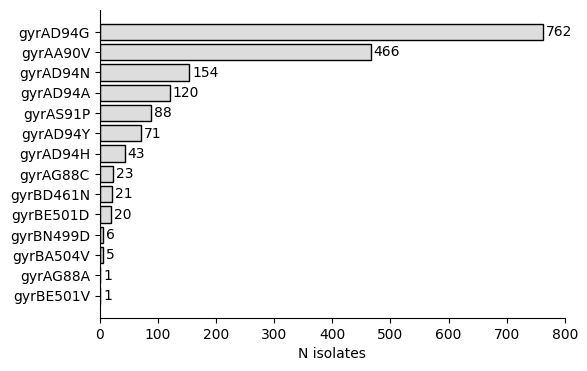

In [17]:
#number of FQ-R isolates iwth catalogue resistance ocnferring mutations
mut_n=[]
for i in catalogue_muts:
    mut_n.append(fq_r_muts.loc[fq_r_muts.GENEMUT==i].UNIQUEID.nunique())
mutn_dict = dict(zip(catalogue_muts, mut_n))
bars=sorted(mut_n)
ind = np.arange(len(bars)) 
print(ind)
fig=plt.figure(figsize=(6,4))
ax=fig.subplots()
ticks=[]
for i in bars:
    ticks.append(list(mutn_dict.keys())[list(mutn_dict.values()).index(i)])
print(ticks)
ticks=['gyrBE501V', 'gyrAG88A', 'gyrBA504V', 'gyrBN499D', 'gyrBE501D', 'gyrBD461N', 'gyrAG88C', 'gyrAD94H', 'gyrAD94Y', 'gyrAS91P', 'gyrAD94A', 'gyrAD94N', 'gyrAA90V', 'gyrAD94G']
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.barh(ind, bars,  color=['#dddddd'], edgecolor='k')
plt.yticks(ind, ticks)
plt.xlabel('N isolates')
for i in range(len(bars)):
    plt.annotate(bars[i], (bars[i]+5,ind[i]), va='center')

In [18]:
#number of catalogue mutations per isoalte
cat_r_i=fq_r_muts.loc[fq_r_muts.GENEMUT.isin(catalogue_muts)]
muts_listed=[]
uid=[]
n=[]
for i in cat_r_i.UNIQUEID.unique():
    for ii in cat_r_i.loc[cat_r_i.UNIQUEID==i].sort_values(by='GENEMUT').GENEMUT.unique():
        muts_listed.append(ii)
        uid.append(i)
        n.append(len(cat_r_i.loc[cat_r_i.UNIQUEID==i].sort_values(by='GENEMUT').GENEMUT.unique()))
        
mult_muts_df=pd.DataFrame(list(zip(uid,muts_listed,n)), columns=['UNIQUEID','GENEMUT','N_MUTS'])


print('1 cat mutation:', mult_muts_df.loc[mult_muts_df.N_MUTS==1].UNIQUEID.nunique())
print('2 cat mutations:', mult_muts_df.loc[mult_muts_df.N_MUTS==2].UNIQUEID.nunique())
print('3+ cat mutations:',mult_muts_df.loc[mult_muts_df.N_MUTS>2].UNIQUEID.nunique())

1 cat mutation: 1709
2 cat mutations: 36
3+ cat mutations: 0


In [30]:
#merge with phenotypes and created df filtered for 2 mutations
pm_df=pd.merge(mult_muts_df,fq_phenotypes,how='left',on='UNIQUEID')
pmm_df=pd.merge(mult_muts_df.loc[mult_muts_df.N_MUTS==2],fq_phenotypes,how='left',on='UNIQUEID')

In [27]:
#create table of most common multiple R mutations and mean LEV/MXF MIC for isolates contianing them
combos=[]
uid=[]
mxf_mic=[]
lev_mic=[]
for i in pmm_df.UNIQUEID.unique():
    combos.append(pmm_df.loc[pmm_df.UNIQUEID==i].GENEMUT.unique()[0]+'+'+pmm_df.loc[pmm_df.UNIQUEID==i].GENEMUT.unique()[1])
    uid.append(i)
    mxf_mic.append(pmm_df.loc[(pmm_df.UNIQUEID==i)&(pmm_df.DRUG=='MXF')].LOG2MIC.unique()[0])
    lev_mic.append(pmm_df.loc[(pmm_df.UNIQUEID==i)&(pmm_df.DRUG=='LEV')].LOG2MIC.unique()[0])

mut_combos_df=pd.DataFrame(list(zip(uid,combos,lev_mic,mxf_mic)), columns=['UNIQUEID','COMBO','LEV_MIC','MXF_MIC'])


combo_count=[]    
for i in list(set(combos)):
    combo_count.append(combos.count(i))
mut_combos_table=pd.DataFrame(list(zip(list(set(combos)),combo_count)), columns=['COMBO','N_ISOLATES']).sort_values(by='N_ISOLATES', ascending=False)

mean_lev_mic=[]
lev_sem=[]
mean_mxf_mic=[]
mxf_sem=[]
for i in mut_combos_table.COMBO.unique():
    mean_lev_mic.append(mut_combos_df.loc[mut_combos_df.COMBO==i].LEV_MIC.mean())
    lev_sem.append(mut_combos_df.loc[mut_combos_df.COMBO==i].LEV_MIC.sem())
    mean_mxf_mic.append(mut_combos_df.loc[mut_combos_df.COMBO==i].MXF_MIC.mean())
    mxf_sem.append(mut_combos_df.loc[mut_combos_df.COMBO==i].MXF_MIC.sem())
mut_combos_table['MEAN_LOG2_LEV_MIC']=mean_lev_mic
mut_combos_table['LEV_SEM']=lev_sem
mut_combos_table['MEAN_LOG2_MXF_MIC']=mean_mxf_mic
mut_combos_table['MXF_SEM']=mxf_sem
mut_combos_table

,COMBO,N_ISOLATES,MEAN_LOG2_LEV_MIC,LEV_SEM,MEAN_LOG2_MXF_MIC,MXF_SEM
7,gyrAA90V+gyrAD94A,10,4.000000,0.000000,3.000,0.000
9,gyrAA90V+gyrAD94G,8,4.000000,0.000000,2.875,0.125
3,gyrAA90V+gyrBD461N,4,4.000000,0.000000,3.000,0.000
6,gyrAA90V+gyrAS91P,4,4.000000,0.000000,3.000,0.000
4,gyrAD94A+gyrBE501D,3,3.333333,0.666667,3.000,0.000
1,gyrAA90V+gyrBA504V,2,4.000000,0.000000,2.500,0.500
0,gyrAD94G+gyrBA504V,1,4.000000,NaN,3.000,NaN
2,gyrAD94A+gyrBA504V,1,1.000000,NaN,0.000,NaN
5,gyrAD94N+gyrBE501D,1,4.000000,NaN,3.000,NaN
8,gyrAD94G+gyrBE501D,1,4.000000,NaN,3.000,NaN


In [36]:
def combo_box_plots(drug,combo):
    '''takes drug string (MXF/LEV) and string of two mutations in the form 'gyrAA90V+gyrAD94A',
    returns boxplot comparing MIC of double mutant vs the mutations as solo'''
    color_dict={'LEV':'#58508d','MXF':'#ff6361'}
    b=pm_df.loc[(pm_df.GENEMUT==combo.split('+')[0])&(pm_df.N_MUTS==1)&(pm_df.DRUG==drug)&(pm_df.PHENOTYPE_QUALITY!='LOW')][['GENEMUT','LOG2MIC']]
    c=pm_df.loc[(pm_df.GENEMUT==combo.split('+')[1])&(pm_df.N_MUTS==1)&(pm_df.DRUG==drug)&(pm_df.PHENOTYPE_QUALITY!='LOW')][['GENEMUT','LOG2MIC']]
    a=mut_combos_df.loc[mut_combos_df.COMBO==combo][['COMBO', drug+'_MIC']]
    a.rename(columns={'COMBO':'GENEMUT', drug+'_MIC':'LOG2MIC'}, inplace=True)
    ab=a.append(b)
    abc=ab.append(c)
    
    plt.figure()

    plt.ylim(-5,7)
    if drug=='MXF':
        plt.axhline(y=3, linestyle='dashed', linewidth=0.4, color='gray')
        plt.axhline(y=-4.06, linestyle='dashed', linewidth=0.4, color='gray')
    if drug=='LEV':
        plt.axhline(y=4, linestyle='dashed', linewidth=0.4, color='gray')
        plt.axhline(y=-3.06, linestyle='dashed', linewidth=0.4, color='gray')
    sns.boxplot(x="GENEMUT", y="LOG2MIC", data=abc, color=color_dict[drug],
            showfliers=False, 
            showmeans=True, meanprops={"marker":"x",'markeredgecolor':'k'})
    
    sns.despine()
    plt.xlabel('')
    plt.ylabel('log2MIC')
# statistical annotation

    if stats.mannwhitneyu(a.LOG2MIC.dropna(),c.LOG2MIC.dropna())[1] <0.01:
        x1, x2 = 0, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = ab['LOG2MIC'].max() + 1, 1, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)



    if stats.mannwhitneyu(a.LOG2MIC.dropna(),b.LOG2MIC.dropna())[1] <0.01:
        x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = ab['LOG2MIC'].max() + 0.5, 0.5, 'k'
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
        
    plt.savefig(combo+'_'+drug+'.png', dpi=300, transparent=True, bbox_inches='tight')


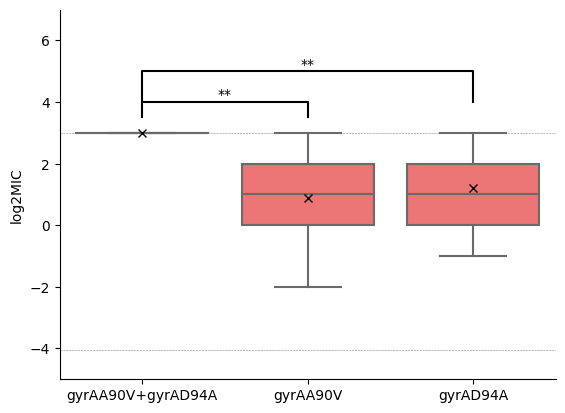

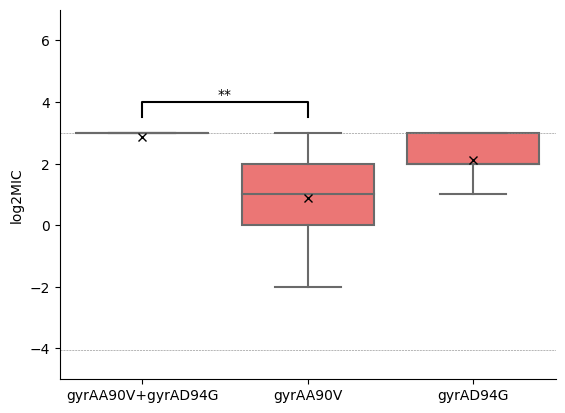

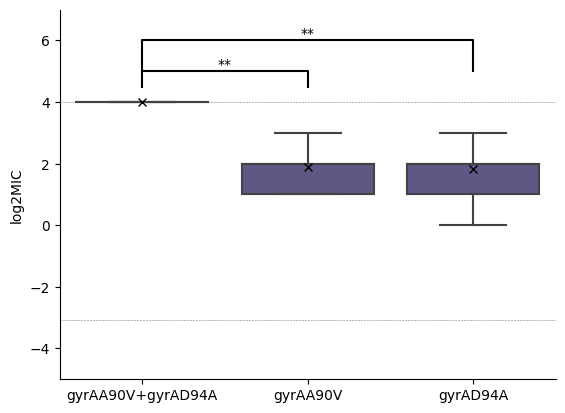

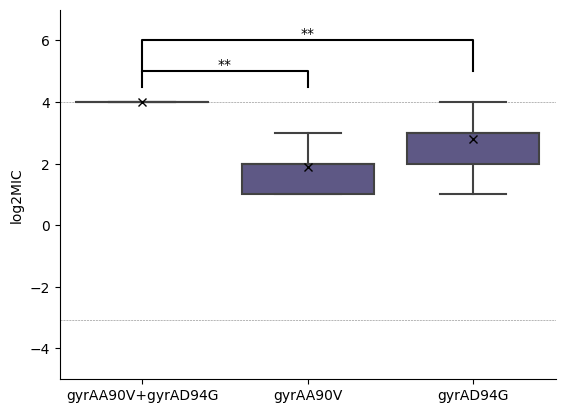

In [37]:
combo_box_plots('MXF','gyrAA90V+gyrAD94A')
combo_box_plots('MXF','gyrAA90V+gyrAD94G')
combo_box_plots('LEV','gyrAA90V+gyrAD94A')
combo_box_plots('LEV','gyrAA90V+gyrAD94G')

In [38]:
#check how many isolates have gyrA T80A + gyrA A90G combo (possible hypersusceptibility)
gyrase_mutations.loc[gyrase_mutations.GENEMUT.isin(['gyrAA90G','gyrAT80A'])]

,UNIQUEID,GENE,MUTATION,POSITION,AMINO_ACID_NUMBER,GENOME_INDEX,NUCLEOTIDE_NUMBER,REF,ALT,IS_SNP,...,IS_NULL,IS_FILTER_PASS,ELEMENT_TYPE,MUTATION_TYPE,INDEL_LENGTH,INDEL_1,INDEL_2,SITEID,NUMBER_NUCLEOTIDE_CHANGES,GENEMUT
5080608,site.11.subj.MDR052.lab.SWE-40.iso.1,gyrA,T80A,80.0,80.0,NaN,NaN,acc,gcc,True,...,False,True,GENE,AAM,NaN,,,11,1,gyrAT80A
5080609,site.11.subj.MDR052.lab.SWE-40.iso.1,gyrA,A90G,90.0,90.0,NaN,NaN,gcg,ggg,True,...,False,True,GENE,AAM,NaN,,,11,1,gyrAA90G
11213059,site.03.subj.GB-90550057.lab.IML-02009.iso.1,gyrA,T80A,80.0,80.0,NaN,NaN,acc,gcc,True,...,False,True,GENE,AAM,NaN,,,03,1,gyrAT80A
11960595,site.03.subj.GB-82740128.lab.82740128.iso.1,gyrA,T80A,80.0,80.0,NaN,NaN,acc,gcc,True,...,False,True,GENE,AAM,NaN,,,03,1,gyrAT80A


In [39]:
#create dataframe with lineage, MDR, country background and presence/absence of R associated mutations
#takes ~1hr
uid=[]
lineage=[]
country=[]
background=[]
mxf_r=[]
lev_r=[]
het=[]
mult_mut=[]

g88a=[]
g88c=[]
d94a=[]
d94g=[]
d94n=[]
d94h=[]
d94y=[]
s91p=[]
a90v=[]
e501d=[]
e501v=[]
d461n=[]
a504v=[]
n499d=[]

cat_mut_dict={'gyrAG88C': g88c,
 'gyrAG88A': g88a,
 'gyrAA90V': a90v,
 'gyrAS91P': s91p,
 'gyrAD94A': d94a,
 'gyrAD94G': d94g,
 'gyrAD94H': d94h,
 'gyrAD94N': d94n,
 'gyrAD94Y': d94y,
 'gyrBE501D': e501d,
 'gyrBE501V': e501v,
 'gyrBN499D': n499d,
 'gyrBA504V': a504v,
 'gyrBD461N': d461n}


for i in gps.UNIQUEID.unique():
    uid.append(i)
    lineage.append(gps.loc[gps.UNIQUEID==i].LINEAGE_NAME.to_list()[0])
    country.append(gps.loc[gps.UNIQUEID==i].COUNTRY_WHERE_SAMPLE_TAKEN.to_list()[0])
    
    u_df=gps.loc[(gps.UNIQUEID==i)]
    if len(u_df.loc[u_df.DRUG=='INH'])+len(u_df.loc[u_df.DRUG=='RIF'])==2:
        if u_df.loc[u_df.DRUG=='INH'].BINARY_PHENOTYPE.to_list()[0]=='R' and u_df.loc[u_df.DRUG=='RIF'].BINARY_PHENOTYPE.to_list()[0]=='R':
            background.append('MDR')
        elif u_df.loc[u_df.DRUG=='INH'].BINARY_PHENOTYPE.to_list()[0]=='S' and u_df.loc[u_df.DRUG=='RIF'].BINARY_PHENOTYPE.to_list()[0]=='S':
            background.append('INH_AND_RIF_S')
        elif u_df.loc[u_df.DRUG=='INH'].BINARY_PHENOTYPE.to_list()[0]=='R' and u_df.loc[u_df.DRUG=='RIF'].BINARY_PHENOTYPE.to_list()[0]=='S':
            background.append('INH_MONOR')
        elif u_df.loc[u_df.DRUG=='INH'].BINARY_PHENOTYPE.to_list()[0]=='S' and u_df.loc[u_df.DRUG=='RIF'].BINARY_PHENOTYPE.to_list()[0]=='R':
            background.append('RIF_MONOR')
        else:
            background.append('UNKNOWN')
    else:
        background.append('UNKNOWN')
        
    if len(u_df.loc[u_df.DRUG=='LEV'])>0:
        lev_r.append(1)
    else:
        lev_r.append(0)

    count=0    
    for ii in catalogue_muts:
        if len(gyrase_mutations.loc[(gyrase_mutations.UNIQUEID==i)&(gyrase_mutations.GENEMUT==ii)])>0:
            cat_mut_dict[ii].append(1)
            count=count+1
        else:
            cat_mut_dict[ii].append(0)
    if count>=2:
        mult_mut.append(1)
    else:
        mult_mut.append(0)

 
    



fq_model_data=pd.DataFrame(list(zip(uid,lineage, country, background,  mult_mut,
                                      g88c,g88a,a90v,s91p,d94a,d94g,d94h,d94n,d94y,e501d,e501v,n499d,a504v,d461n)),
               columns =['UNIQUEID','LINEAGE','COUNTRY','BACKGROUND', 'MULT_MUT',  
                         'G88C','G88A','A90V','S91P','D94A','D94G', 'D94H','D94N','D94Y', 'E501D','E501V', 'N499D','A504V','D461N'])

fq_r_model_data=fq_model_data.loc[fq_model_data.UNIQUEID.isin(fq_r_muts.UNIQUEID.unique())]
fq_r_model_data=fq_r_model_data.loc[fq_r_model_data.COUNTRY.isin(['BRA','CHN','DEU','IND','ITA','KGZ','NPL','PAK','PER','TKM','VNM','ZAF'])]

15211 15211 15211 15211


,UNIQUEID,LINEAGE,COUNTRY,BACKGROUND,MULT_MUT,G88C,G88A,A90V,S91P,D94A,D94G,D94H,D94N,D94Y,E501D,E501V,N499D,A504V,D461N
0,site.02.subj.0958.lab.22A197.iso.1,Lineage 2,CHN,MDR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,site.02.subj.0823.lab.2013241494.iso.1,Lineage 4,CHN,INH_AND_RIF_S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,site.02.subj.0359.lab.222018-14.iso.1,Lineage 2,CHN,INH_AND_RIF_S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,site.02.subj.0224.lab.2013221088.iso.1,Lineage 2,CHN,MDR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,site.02.subj.0918.lab.22A153.iso.1,Lineage 2,CHN,MDR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15206,site.10.subj.YA00033558.lab.YA00033558.iso.1,Lineage 4,ZAF,INH_AND_RIF_S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15207,site.10.subj.YA00008913.lab.YA00008913.iso.1,Lineage 1,ZAF,MDR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15208,site.10.subj.YA00023171.lab.YA00023171.iso.1,Lineage 4,ZAF,INH_AND_RIF_S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15209,site.10.subj.YA00044774.lab.YA00044774.iso.1,Lineage 4,ZAF,INH_AND_RIF_S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
#one hot encode catagorical features
fq_model_data_1hot=pd.get_dummies(fq_r_model_data, columns=['LINEAGE', 'COUNTRY', 'BACKGROUND' ], sparse=True)

In [45]:
#check VIF scores and run logreg to find associations with presence of mutations, saved as mutation+'_associations_LR.csv'
for i in ['A90V','D94G']:
    
    X = fq_model_data_1hot[[
     'LINEAGE_Lineage 1',
     'LINEAGE_Lineage 3',
     'LINEAGE_Lineage 4',
     'COUNTRY_BRA',
     'COUNTRY_CHN',
     'COUNTRY_DEU',
     'COUNTRY_ITA',
     'COUNTRY_KGZ',
     'COUNTRY_NPL',
     'COUNTRY_PAK',
     'COUNTRY_PER',
     'COUNTRY_TKM',
     'COUNTRY_VNM',
     'COUNTRY_ZAF',
     'BACKGROUND_INH_AND_RIF_S',
     'BACKGROUND_INH_MONOR']]

    X['int']=1
    
    y = fq_model_data_1hot[[i]]

    #calculate Variance Inflation Factor

    vif_scores = pd.DataFrame() 
    vif_scores["Attribute"] = X.columns 
  
    # calculating VIF for each feature 
    vif_scores["VIF Scores"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
    display(vif_scores)

    #fit logisitc regression
    logit_model=sm.Logit(y,X).fit()
    stats2=logit_model.summary2()
    stats2.tables[1]['Adj. OR']=np.exp(logit_model.params)
    stats2.tables[1]['Adj. [0.025']=np.exp(stats2.tables[1]['[0.025'])
    stats2.tables[1]['Adj. 0.975]']=np.exp(stats2.tables[1]['0.975]'])
    stats2.tables[1]['Corr. p']=multipletests(logit_model.pvalues, method='bonferroni')[1]

    stats2.tables[1].to_csv(i+'_associations_LR.csv')

<ipython-input-45-a0e8980ee1cc>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['int']=1


,Attribute,VIF Scores
0,LINEAGE_Lineage 1,1.088034
1,LINEAGE_Lineage 3,1.878882
2,LINEAGE_Lineage 4,1.536398
3,COUNTRY_BRA,1.085079
4,COUNTRY_CHN,1.237340
5,COUNTRY_DEU,1.036216
6,COUNTRY_ITA,1.102423
7,COUNTRY_KGZ,1.020513
8,COUNTRY_NPL,1.155658
9,COUNTRY_PAK,1.786190


Optimization terminated successfully.
         Current function value: 0.508851
         Iterations 7


<ipython-input-45-a0e8980ee1cc>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['int']=1


,Attribute,VIF Scores
0,LINEAGE_Lineage 1,1.088034
1,LINEAGE_Lineage 3,1.878882
2,LINEAGE_Lineage 4,1.536398
3,COUNTRY_BRA,1.085079
4,COUNTRY_CHN,1.237340
5,COUNTRY_DEU,1.036216
6,COUNTRY_ITA,1.102423
7,COUNTRY_KGZ,1.020513
8,COUNTRY_NPL,1.155658
9,COUNTRY_PAK,1.786190


Optimization terminated successfully.
         Current function value: 0.616802
         Iterations 7


In [46]:
def mic_linear_regression(drug, mutation):
    '''find associations between background factors and MIC,
    takes drug string (lev/MXF), and mutations string e.g. D94G,
    returns mutation+'_'+drug+'_mic_associations_LR.csv with results of linear regression'''
    mic_model_data = pd.merge(fq_model_data, phenotypes.loc[phenotypes.DRUG==drug][['UNIQUEID','LOG2MIC','PHENOTYPE_QUALITY']], on='UNIQUEID')
    mic_model_data=mic_model_data.loc[(mic_model_data[mutation]==1)&(-mic_model_data.LOG2MIC.isna())&
                                          (mic_model_data.PHENOTYPE_QUALITY!='LOW')&
                                       (mic_model_data.COUNTRY.isin(['CHN','IND','ITA','NPL','PAK','PER','ZAF']))]
    mic_model_data_1hot=pd.get_dummies(mic_model_data, columns=['LINEAGE', 'COUNTRY', 'BACKGROUND' ], sparse=True)

    X = mic_model_data_1hot[[
    'LINEAGE_Lineage 1',
     'LINEAGE_Lineage 3',
     'LINEAGE_Lineage 4',       
     'COUNTRY_CHN',
     'COUNTRY_ITA',
     'COUNTRY_NPL',
     'COUNTRY_PAK',
     'COUNTRY_PER',
     'COUNTRY_ZAF',   
     'MULT_MUT',
     'BACKGROUND_INH_AND_RIF_S',
     'BACKGROUND_INH_MONOR']]

    X['int']=1
    y = mic_model_data_1hot[['LOG2MIC']]

    #calculate Variance Inflation Factor
    vif_scores = pd.DataFrame() 
    vif_scores["Attribute"] = X.columns 
    vif_scores["VIF Scores"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
    display(vif_scores)
    
    #fit linear regression
    ols=sm.OLS(y,X).fit()
    stats2=ols.summary2()
    stats2.tables[1]['Corr. p']=multipletests(ols.pvalues, method='bonferroni')[1]
    stats2.tables[1].to_csv(mutation+'_'+drug+'_mic_associations_LR.csv')


In [47]:
#run linear regression to find associations between background and MIC depending on R mutation
mic_linear_regression('LEV', 'D94G')
mic_linear_regression('MXF', 'D94G')
mic_linear_regression('LEV', 'A90V')
mic_linear_regression('MXF', 'A90V')

<ipython-input-46-63e96d7917d2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['int']=1


,Attribute,VIF Scores
0,LINEAGE_Lineage 1,1.024296
1,LINEAGE_Lineage 3,1.783544
2,LINEAGE_Lineage 4,1.447182
3,COUNTRY_CHN,1.106736
4,COUNTRY_ITA,1.101983
5,COUNTRY_NPL,1.161955
6,COUNTRY_PAK,1.735661
7,COUNTRY_PER,1.495043
8,COUNTRY_ZAF,1.232139
9,MULT_MUT,1.012339


<ipython-input-46-63e96d7917d2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['int']=1


,Attribute,VIF Scores
0,LINEAGE_Lineage 1,1.025107
1,LINEAGE_Lineage 3,1.798143
2,LINEAGE_Lineage 4,1.638568
3,COUNTRY_CHN,1.101965
4,COUNTRY_ITA,1.100116
5,COUNTRY_NPL,1.127571
6,COUNTRY_PAK,1.773459
7,COUNTRY_PER,1.675832
8,COUNTRY_ZAF,1.200635
9,MULT_MUT,1.012231


<ipython-input-46-63e96d7917d2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['int']=1


,Attribute,VIF Scores
0,LINEAGE_Lineage 1,1.215623
1,LINEAGE_Lineage 3,1.701599
2,LINEAGE_Lineage 4,1.669301
3,COUNTRY_CHN,1.193499
4,COUNTRY_ITA,1.124676
5,COUNTRY_NPL,1.264745
6,COUNTRY_PAK,1.647043
7,COUNTRY_PER,1.524980
8,COUNTRY_ZAF,1.317983
9,MULT_MUT,1.101091


<ipython-input-46-63e96d7917d2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['int']=1


,Attribute,VIF Scores
0,LINEAGE_Lineage 1,1.206143
1,LINEAGE_Lineage 3,1.543080
2,LINEAGE_Lineage 4,1.634802
3,COUNTRY_CHN,1.179311
4,COUNTRY_ITA,1.111664
5,COUNTRY_NPL,1.198120
6,COUNTRY_PAK,1.550336
7,COUNTRY_PER,1.555227
8,COUNTRY_ZAF,1.285527
9,MULT_MUT,1.092875


In [77]:
fq_r=[]
l1=[]
l2=[]
l3=[]
l4=[]
countries=fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN.dropna().unique().to_list()
for i in countries:
    fq_r.append(fq_r_df.loc[fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN==i].UNIQUEID.nunique())
    l1.append(fq_r_df.loc[(fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN==i)&(fq_r_df.LINEAGE_NAME=='Lineage 1')].UNIQUEID.nunique())
    l2.append(fq_r_df.loc[(fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN==i)&(fq_r_df.LINEAGE_NAME=='Lineage 2')].UNIQUEID.nunique())
    l3.append(fq_r_df.loc[(fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN==i)&(fq_r_df.LINEAGE_NAME=='Lineage 3')].UNIQUEID.nunique())
    l4.append(fq_r_df.loc[(fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN==i)&(fq_r_df.LINEAGE_NAME=='Lineage 4')].UNIQUEID.nunique())

fq_r.append(fq_r_df.loc[fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN.isna()].UNIQUEID.nunique())
countries.append('UNKNOWN')
l1.append(fq_r_df.loc[(fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN.isna())&(fq_r_df.LINEAGE_NAME=='Lineage 1')].UNIQUEID.nunique())
l2.append(fq_r_df.loc[(fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN.isna())&(fq_r_df.LINEAGE_NAME=='Lineage 2')].UNIQUEID.nunique())
l3.append(fq_r_df.loc[(fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN.isna())&(fq_r_df.LINEAGE_NAME=='Lineage 3')].UNIQUEID.nunique())
l4.append(fq_r_df.loc[(fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN.isna())&(fq_r_df.LINEAGE_NAME=='Lineage 4')].UNIQUEID.nunique())

fq_r_summary=pd.DataFrame(list(zip(countries, fq_r, l1, l2, l3, l4)),
               columns =['COUNTRY','FQ_R', 'L1', 'L2', 'L3', 'L4'])
fq_r_summary

,COUNTRY,FQ_R,L1,L2,L3,L4
0,CHN,164,0,132,0,32
1,PER,169,0,21,0,148
2,VNM,34,6,27,0,1
3,BRA,20,0,0,0,20
4,ZAF,298,6,203,1,88
5,IND,583,32,405,71,75
6,NPL,133,1,118,5,9
7,KGZ,11,0,10,0,1
8,DEU,28,0,17,3,8
9,TJK,3,0,3,0,0


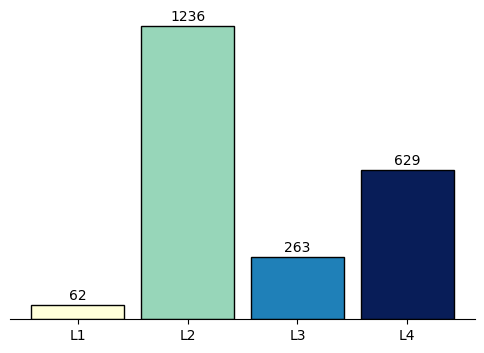

In [80]:
#lineage background of fq resistant isolates

width = 0.85  
bars=[]
bars.append(fq_r_summary.L1.sum())
bars.append(fq_r_summary.L2.sum())
bars.append(fq_r_summary.L3.sum())
bars.append(fq_r_summary.L4.sum())
ind = np.arange(len(bars)) 

plt.figure(figsize=(len(bars)*1.5,4))

plt.bar(ind, bars, width, color=['#ffffd9','#97d6b9','#1f80b8','#081d58'], edgecolor='k')

#plt.ylabel('N     ', rotation=0)

plt.xticks(ind, ['L1','L2','L3','L4'])

for i in range(0,len(bars)):
      plt.text(i, bars[i]+10, str(bars[i]), ha = 'center', va='bottom')

for pos in ['right', 'top', 'left']: 
    plt.gca().spines[pos].set_visible(False) 

plt.tick_params(left = False, right = False , labelleft = False)

plt.savefig('fq_r_lineage_distribution.png', dpi=300, transparent=True, bbox_inches='tight')

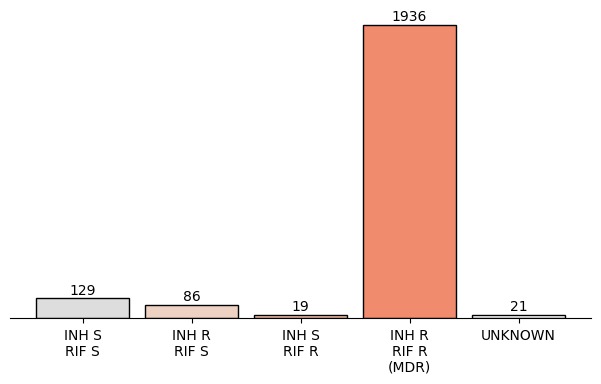

In [53]:
#rifampicin isoniazid resistance background of fq resistant isolates

inh_rif_s=0
inh_mono=0
rif_mono=0
mdr=0
uk=0
for i in fq_r_df.UNIQUEID.unique():
    u_df=gps.loc[(gps.UNIQUEID==i)]

    if u_df.loc[u_df.DRUG=='INH'].BINARY_PHENOTYPE.to_list()[0]=='R' and u_df.loc[u_df.DRUG=='RIF'].BINARY_PHENOTYPE.to_list()[0]=='R':
        mdr=mdr+1
    elif u_df.loc[u_df.DRUG=='INH'].BINARY_PHENOTYPE.to_list()[0]=='S' and u_df.loc[u_df.DRUG=='RIF'].BINARY_PHENOTYPE.to_list()[0]=='S':
        inh_rif_s=inh_rif_s+1
    elif u_df.loc[u_df.DRUG=='INH'].BINARY_PHENOTYPE.to_list()[0]=='R' and u_df.loc[u_df.DRUG=='RIF'].BINARY_PHENOTYPE.to_list()[0]=='S':
        inh_mono=inh_mono+1
    elif u_df.loc[u_df.DRUG=='INH'].BINARY_PHENOTYPE.to_list()[0]=='S' and u_df.loc[u_df.DRUG=='RIF'].BINARY_PHENOTYPE.to_list()[0]=='R':
        rif_mono=rif_mono+1
    else:
        uk=uk+1
        
width = 0.85  
bars=[]
bars.append(inh_rif_s)
bars.append(inh_mono)
bars.append(rif_mono)
bars.append(mdr)
bars.append(uk)
ind = np.arange(len(bars)) 

plt.figure(figsize=(len(bars)*1.5,4))

plt.bar(ind, bars, width, color=['#dddddd','#edd1c2','#f6bfa6','#f08b6d','w'], edgecolor='k')


plt.xticks(ind, ['INH S\nRIF S', 'INH R\nRIF S', 'INH S\nRIF R', 'INH R\nRIF R\n(MDR)', 'UNKNOWN'])

for i in range(0,len(bars)):
      plt.text(i, bars[i]+10, str(bars[i]), ha = 'center', va='bottom')

for pos in ['right', 'top', 'left']: 
    plt.gca().spines[pos].set_visible(False) 

plt.tick_params(left = False, right = False , labelleft = False)

plt.savefig('fq_inh_rif_distribution.png', dpi=300, transparent=True, bbox_inches='tight')

In [56]:
fq_r=[]
lev_r=[]
mxf_r=[]
both_r=[]
lev_only=[]
mxf_only=[]

countries=fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN.dropna().unique().to_list()
for i in countries:
    lev_r_i=0
    mxf_r_i=0
    both_r_i=0

    country_df_list=fq_r_df.loc[fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN==i].UNIQUEID.unique()
    for ii in country_df_list:
        u_df=gps.loc[(gps.UNIQUEID==ii)]
        if u_df.loc[u_df.DRUG=='LEV'].BINARY_PHENOTYPE.to_list()[0]=='R' and u_df.loc[u_df.DRUG=='MXF'].BINARY_PHENOTYPE.to_list()[0]!='R':
            lev_r_i=lev_r_i+1
        if u_df.loc[u_df.DRUG=='MXF'].BINARY_PHENOTYPE.to_list()[0]=='R' and u_df.loc[u_df.DRUG=='LEV'].BINARY_PHENOTYPE.to_list()[0]!='R':
            mxf_r_i=mxf_r_i+1
        if u_df.loc[u_df.DRUG=='MXF'].BINARY_PHENOTYPE.to_list()[0]=='R' and u_df.loc[u_df.DRUG=='LEV'].BINARY_PHENOTYPE.to_list()[0]=='R':
            both_r_i=both_r_i+1


   

    fq_r.append(fq_r_df.loc[fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN==i].UNIQUEID.nunique())
    
    lev_r.append(lev_r_i)
    mxf_r.append(mxf_r_i)
    both_r.append(both_r_i)


na_df_list=fq_r_df.loc[fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN.isna()].UNIQUEID.unique()
for ii in na_df_list:
    u_df=gps.loc[(gps.UNIQUEID==ii)]
    if u_df.loc[u_df.DRUG=='LEV'].BINARY_PHENOTYPE.to_list()[0]=='R' and u_df.loc[u_df.DRUG=='MXF'].BINARY_PHENOTYPE.to_list()[0]!='R':
        lev_r_i=lev_r_i+1
    if u_df.loc[u_df.DRUG=='MXF'].BINARY_PHENOTYPE.to_list()[0]=='R' and u_df.loc[u_df.DRUG=='LEV'].BINARY_PHENOTYPE.to_list()[0]!='R':
        mxf_r_i=mxf_r_i+1
    if u_df.loc[u_df.DRUG=='MXF'].BINARY_PHENOTYPE.to_list()[0]=='R' and u_df.loc[u_df.DRUG=='LEV'].BINARY_PHENOTYPE.to_list()[0]=='R':
        both_r_i=both_r_i+1

lev_r.append(lev_r_i)
mxf_r.append(mxf_r_i)
both_r.append(both_r_i)

fq_r.append(fq_r_df.loc[fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN.isna()].UNIQUEID.nunique())
countries.append('UNKNOWN')
            
fq_r_summary=pd.DataFrame(list(zip(countries, fq_r, lev_r, mxf_r, both_r)),
               columns =['COUNTRY','FQ_R', 'lev_r', 'mxf_r', 'both_r'])
fq_r_summary

,COUNTRY,FQ_R,lev_r,mxf_r,both_r
0,CHN,164,31,5,128
1,PER,169,26,1,142
2,VNM,34,17,2,15
3,BRA,20,6,1,13
4,ZAF,298,28,6,264
5,IND,583,94,18,471
6,NPL,133,26,0,107
7,KGZ,11,4,0,7
8,DEU,28,10,1,17
9,TJK,3,1,0,2


In [57]:
countries = pd.read_csv("../cryptic_data_analysis/data_tables/cryptic-analysis-group/COUNTRIES_LOOKUP.csv")
#create world df for % of isoaltes that were S
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
tb_world=pd.merge(world, fq_r_summary, left_on='iso_a3', right_on='COUNTRY', how='left')

tb_world_pies=tb_world.loc[(tb_world['FQ_R']>=0)]
tb_world_pies=pd.merge(tb_world_pies,countries, how='left', left_on='COUNTRY', right_on='COUNTRY_CODE_3_LETTER')



lat=tb_world_pies.LAT
long=tb_world_pies.LONG
#pick out R categories for pie charts
r1=tb_world_pies.lev_r
r2=tb_world_pies.mxf_r
r3=tb_world_pies.both_r


u1=fq_r_summary.loc[fq_r_summary.COUNTRY=='UNKNOWN'].lev_r.to_list()[0]
u2=fq_r_summary.loc[fq_r_summary.COUNTRY=='UNKNOWN'].mxf_r.to_list()[0]
u3=fq_r_summary.loc[fq_r_summary.COUNTRY=='UNKNOWN'].both_r.to_list()[0]

t1=fq_r_summary.lev_r.sum()
t2=fq_r_summary.mxf_r.sum()
t3=fq_r_summary.both_r.sum()


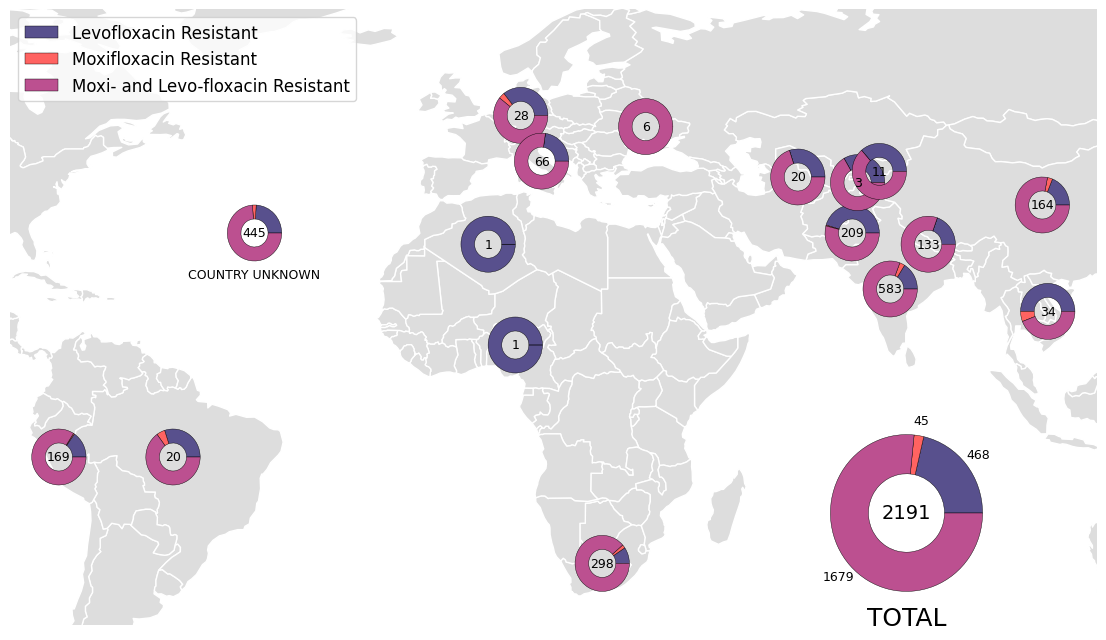

In [58]:

#make map of FQ R distribution
fig, ax = plt.subplots(1, 1,figsize=(15,8))
for i in range(len(tb_world_pies)):
    center=(long[i],lat[i])
    patches, texts=ax.pie([r1[i],r2[i],r3[i]],radius=5,
                   colors=['#58508d','#ff6361','#bc5090'], 
                          center=center)
    plt.setp( patches, width=2.5, edgecolor='k', linewidth=0.3)
    ax.legend(patches,['Levofloxacin Resistant','Moxifloxacin Resistant','Moxi- and Levo-floxacin Resistant'], fontsize=12,loc='upper left')
    plt.text(long[i],lat[i], tb_world_pies.FQ_R.astype('int64').to_list()[i], ha='center', va='center', size=9)

center=(-40,30)
patches, texts=ax.pie([u1,u2,u3],radius=5,
                   colors=['#58508d','#ff6361','#bc5090'], 
                          center=center)
plt.setp( patches, width=2.5, edgecolor='k', linewidth=0.3)
plt.text(-40,22, 'COUNTRY UNKNOWN', ha='center', size=9)
plt.text(-40,30, fq_r_summary.loc[fq_r_summary.COUNTRY=='UNKNOWN'].FQ_R.astype('int64').to_list()[0], ha='center', va='center', size=9)

center=(80,-20)
patches, texts=ax.pie([t1,t2,t3],radius=14,
                   colors=['#58508d','#ff6361','#bc5090'], 
                          center=center, labels=[str(t1),str(t2),str(t3)], labeldistance=1.2, textprops={'va':'center','ha':'center','size':9})
plt.setp( patches, width=7, edgecolor='k', linewidth=0.3)
plt.text(80,-40, 'TOTAL', ha='center', size=18)
plt.text(80,-20, int(fq_r_summary.FQ_R.sum()), ha='center', va='center', size=14)



background=world.plot(ax=ax, color='#dddddd', edgecolor='w')
#wp=tb_world.loc[tb_world.COUNTRY!='UNKNOWN'].plot(ax=ax,edgecolor='w',
 #                figsize=(10, 10),
  #               color='grey')

ax.set_xlim(-85,115)
ax.set_ylim(-40,70)


plt.savefig('fq_r_map_fig.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [64]:
rif_s=gps.loc[(gps.DRUG=='RIF')&(gps.BINARY_PHENOTYPE=='S')].UNIQUEID.to_list()
inh_s=gps.loc[(gps.DRUG=='INH')&(gps.BINARY_PHENOTYPE=='S')].UNIQUEID.to_list()
randi_s_fq=gps.loc[(gps.DRUG.isin(['LEV','MXF']))&(-gps.BINARY_PHENOTYPE.isna())
                          &(gps.UNIQUEID.isin(rif_s))&(gps.UNIQUEID.isin(inh_s))]
randi_s_lev=randi_s_fq.loc[(randi_s_fq.DRUG=='LEV')&(-randi_s_fq.BINARY_PHENOTYPE.isna())]
randi_s_mxf=randi_s_fq.loc[(randi_s_fq.DRUG=='MXF')&(-randi_s_fq.BINARY_PHENOTYPE.isna())]

In [66]:
total_r=[]
r=[]
total_s_r=[]
s_r=[]
total_inh_r=[]
inh_r=[]
total_rif_r=[]
rif_r=[]
total_mdr=[]
mdr=[]

for i in ['FQ','LEV','MXF']:
    if i == 'FQ':
        total_r.append(drugs_df.loc[(drugs_df.sum(axis=1)>=1)&((-drugs_df.LEV.isna())|(-drugs_df.MXF.isna()))].UNIQUEID.nunique())
        r.append(drugs_df.loc[((drugs_df.MXF==1)|(drugs_df.LEV==1))].UNIQUEID.nunique())
        total_mdr.append(drugs_df.loc[(drugs_df.RIF==1)&(drugs_df.INH==1)&((-drugs_df.LEV.isna())|(-drugs_df.MXF.isna()))].UNIQUEID.nunique())
        mdr.append(drugs_df.loc[(drugs_df.RIF==1)&(drugs_df.INH==1)&((drugs_df.MXF==1)|(drugs_df.LEV==1))].UNIQUEID.nunique())
        total_s_r.append(randi_s_fq.UNIQUEID.nunique())
        s_r.append(randi_s_fq.loc[randi_s_fq.BINARY_PHENOTYPE =='R'].UNIQUEID.nunique())
        total_inh_r.append(drugs_df.loc[(drugs_df.RIF==0)&(drugs_df.INH==1)&((-drugs_df.LEV.isna())|(-drugs_df.MXF.isna()))].UNIQUEID.nunique())
        inh_r.append(drugs_df.loc[(drugs_df.RIF==0)&(drugs_df.INH==1)&((drugs_df.MXF==1)|(drugs_df.LEV==1))].UNIQUEID.nunique())
        total_rif_r.append(drugs_df.loc[(drugs_df.RIF==1)&(drugs_df.INH==0)&((-drugs_df.LEV.isna())|(-drugs_df.MXF.isna()))].UNIQUEID.nunique())
        rif_r.append(drugs_df.loc[(drugs_df.RIF==1)&(drugs_df.INH==0)&((drugs_df.MXF==1)|(drugs_df.LEV==1))].UNIQUEID.nunique())
    else:
        total_r.append(drugs_df.loc[(drugs_df.sum(axis=1)>=1)&(-drugs_df[i].isna())].UNIQUEID.nunique())
        r.append(drugs_df.loc[(drugs_df[i]==1)].UNIQUEID.nunique())
        total_mdr.append(drugs_df.loc[(drugs_df.RIF==1)&(drugs_df.INH==1)&(-drugs_df[i].isna())].UNIQUEID.nunique())
        mdr.append(drugs_df.loc[(drugs_df.RIF==1)&(drugs_df.INH==1)&(drugs_df[i]==1)].UNIQUEID.nunique())
        total_inh_r.append(drugs_df.loc[(drugs_df.RIF==0)&(drugs_df.INH==1)&(-drugs_df[i].isna())].UNIQUEID.nunique())
        inh_r.append(drugs_df.loc[(drugs_df.RIF==0)&(drugs_df.INH==1)&(drugs_df[i]==1)].UNIQUEID.nunique())
        total_rif_r.append(drugs_df.loc[(drugs_df.RIF==1)&(drugs_df.INH==0)&(-drugs_df[i].isna())].UNIQUEID.nunique())
        rif_r.append(drugs_df.loc[(drugs_df.RIF==1)&(drugs_df.INH==0)&(drugs_df[i]==1)].UNIQUEID.nunique())
        if i == 'LEV':
            total_s_r.append(randi_s_lev.UNIQUEID.nunique())
            s_r.append(randi_s_lev.loc[randi_s_lev.BINARY_PHENOTYPE =='R'].UNIQUEID.nunique())
        elif i == 'MXF':
            total_s_r.append(randi_s_mxf.UNIQUEID.nunique())
            s_r.append(randi_s_mxf.loc[randi_s_mxf.BINARY_PHENOTYPE =='R'].UNIQUEID.nunique())

fq_prev_totals=pd.DataFrame(list(zip(r,total_r,s_r,total_s_r,inh_r,total_inh_r,rif_r,total_rif_r,mdr, total_mdr)),
               columns =['R','TOTAL_R','S', 'TOTAL_S','INH_R', 'TOTAL_INH_R','RIF_R', 'TOTAL_RIF_R','MDR','TOTAL_MDR'], index=['FQ','LEV','MXF'])


fq_prev_totals


,R,TOTAL_R,S,TOTAL_S,INH_R,TOTAL_INH_R,RIF_R,TOTAL_RIF_R,MDR,TOTAL_MDR
FQ,2191,6800,129,5779,86,1469,19,300,1936,4348
LEV,2146,6753,125,5745,82,1459,19,297,1900,4328
MXF,1724,6760,71,5761,58,1462,14,297,1568,4331


In [68]:
fq_prev_totals_for_graph=fq_prev_totals
fq_prev_totals_for_graph['%R']=fq_prev_totals_for_graph['R']/fq_prev_totals_for_graph['TOTAL_R']
fq_prev_totals_for_graph['%S']=fq_prev_totals_for_graph['S']/fq_prev_totals_for_graph['TOTAL_S']
fq_prev_totals_for_graph['%INH_R']=fq_prev_totals_for_graph['INH_R']/fq_prev_totals_for_graph['TOTAL_INH_R']
fq_prev_totals_for_graph['%RIF_R']=fq_prev_totals_for_graph['RIF_R']/fq_prev_totals_for_graph['TOTAL_RIF_R']
fq_prev_totals_for_graph['%MDR']=fq_prev_totals_for_graph['MDR']/fq_prev_totals_for_graph['TOTAL_MDR']
fq_prev_totals_for_graph=fq_prev_totals_for_graph.drop(columns=['R','TOTAL_R','S', 'TOTAL_S','INH_R', 'TOTAL_INH_R','RIF_R', 'TOTAL_RIF_R','MDR','TOTAL_MDR'])
fq_prev_totals_for_graph=fq_prev_totals_for_graph.transpose()


In [69]:
fq_prev_totals_for_graph

,FQ,LEV,MXF
%R,0.322206,0.317785,0.255030
%S,0.022322,0.021758,0.012324
%INH_R,0.058543,0.056203,0.039672
%RIF_R,0.063333,0.063973,0.047138
%MDR,0.445262,0.439002,0.362041


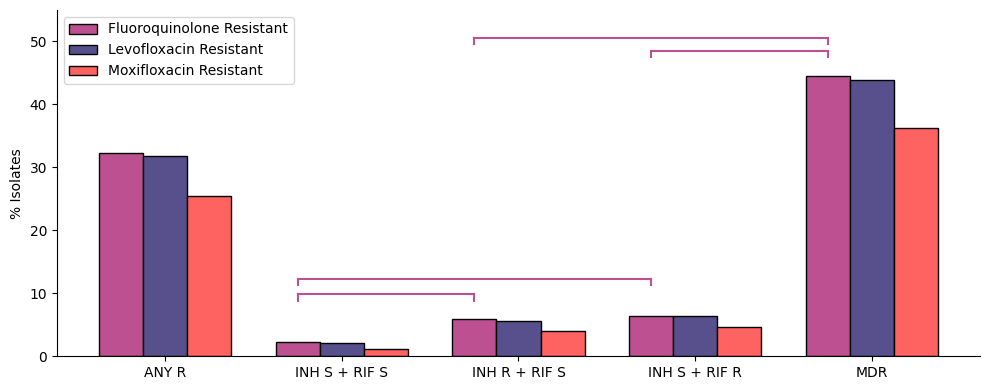

In [76]:

labels = ['ANY R', 'INH S + RIF S', 'INH R + RIF S', 'INH S + RIF R', 'MDR']
FQ = fq_prev_totals_for_graph.FQ*100
LEV = fq_prev_totals_for_graph.LEV*100
MXF = fq_prev_totals_for_graph.MXF*100


x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10,4))
rects1 = ax.bar(x - width, FQ, width, label='Fluoroquinolone Resistant', color='#bc5090',edgecolor='k')
rects2 = ax.bar(x, LEV, width, label='Levofloxacin Resistant', color='#58508d',edgecolor='k')
rects3 = ax.bar(x + width, MXF, width, label='Moxifloxacin Resistant', color='#ff6361',edgecolor='k')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% Isolates')
ax.set_xticks(x)
ax.set_ylim(0,55)
ax.set_xticklabels(labels)
ax.legend()



fq_prev_totals=fq_prev_totals.transpose()
if z_test(fq_prev_totals.FQ[['INH_R']],fq_prev_totals.FQ[['TOTAL_INH_R']],fq_prev_totals.FQ[['RIF_R']],fq_prev_totals.FQ[['TOTAL_RIF_R']])<=0.025:
    plt.plot([x[3]-width, x[4]-width], [FQ[3]+5, FQ[4]+5],color="k")
if z_test(fq_prev_totals.FQ[['RIF_R']],fq_prev_totals.FQ[['TOTAL_RIF_R']],fq_prev_totals.FQ[['MDR']],fq_prev_totals.FQ[['TOTAL_MDR']])<=0.025:
    plt.plot([x[3]-width, x[4]-width], [max(FQ[3],FQ[4])+4, max(FQ[3],FQ[4])+4],color="#bc5090")
    plt.plot([x[3]-width, x[3]-width], [max(FQ[3],FQ[4])+3, max(FQ[3],FQ[4])+4],color="#bc5090")
    plt.plot([x[4]-width, x[4]-width], [max(FQ[3],FQ[4])+3, max(FQ[3],FQ[4])+4],color="#bc5090")
if z_test(fq_prev_totals.FQ[['INH_R']],fq_prev_totals.FQ[['TOTAL_INH_R']],fq_prev_totals.FQ[['MDR']],fq_prev_totals.FQ[['TOTAL_MDR']])<=0.025:
    plt.plot([x[2]-width, x[4]-width], [max(FQ[2],FQ[4])+6, max(FQ[2],FQ[4])+6],color="#bc5090")
    plt.plot([x[2]-width, x[2]-width], [max(FQ[2],FQ[4])+5, max(FQ[2],FQ[4])+6],color="#bc5090")
    plt.plot([x[4]-width, x[4]-width], [max(FQ[2],FQ[4])+5, max(FQ[2],FQ[4])+6],color="#bc5090")
    
    
if z_test(fq_prev_totals.FQ[['INH_R']],fq_prev_totals.FQ[['TOTAL_INH_R']],fq_prev_totals.FQ[['S']],fq_prev_totals.FQ[['TOTAL_S']])<=0.025:
    plt.plot([x[1]-width, x[2]-width], [max(FQ[1],FQ[2])+4, max(FQ[1],FQ[2])+4],color="#bc5090")
    plt.plot([x[1]-width, x[1]-width], [max(FQ[1],FQ[2])+3, max(FQ[1],FQ[2])+4],color="#bc5090")
    plt.plot([x[2]-width, x[2]-width], [max(FQ[1],FQ[2])+3, max(FQ[1],FQ[2])+4],color="#bc5090")

if z_test(fq_prev_totals.FQ[['RIF_R']],fq_prev_totals.FQ[['TOTAL_RIF_R']],fq_prev_totals.FQ[['S']],fq_prev_totals.FQ[['TOTAL_S']])<=0.025:
    plt.plot([x[1]-width, x[3]-width], [max(FQ[1],FQ[3])+6, max(FQ[1],FQ[3])+6],color="#bc5090")
    plt.plot([x[1]-width, x[1]-width], [max(FQ[1],FQ[3])+5, max(FQ[1],FQ[3])+6],color="#bc5090")
    plt.plot([x[3]-width, x[3]-width], [max(FQ[1],FQ[3])+5, max(FQ[1],FQ[3])+6],color="#bc5090")
    
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False) 


        
fig.tight_layout()
plt.savefig('fq_prevalence_fig.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [484]:

fq_r=[]
total=[]

countries=fq_r_df.COUNTRY_WHERE_SAMPLE_TAKEN.dropna().unique().to_list()
for i in countries:
    country_df_list=gps.loc[gps.COUNTRY_WHERE_SAMPLE_TAKEN==i].UNIQUEID.unique()
    fq_r.append(drugs_df.loc[(drugs_df.UNIQUEID.isin(country_df_list))
                             &(drugs_df.RIF==1)&(drugs_df.INH==1)
                             &((drugs_df.MXF==1)|(drugs_df.LEV==1))].UNIQUEID.nunique())
    total.append(drugs_df.loc[(drugs_df.UNIQUEID.isin(country_df_list))
                              &(drugs_df.RIF==1)&(drugs_df.INH==1)
                              &((-drugs_df.LEV.isna())|(-drugs_df.MXF.isna()))].UNIQUEID.nunique())

    
na_df_list=gps.loc[gps.COUNTRY_WHERE_SAMPLE_TAKEN.isna()].UNIQUEID.unique()
fq_r.append(drugs_df.loc[(drugs_df.UNIQUEID.isin(na_df_list))
                             &(drugs_df.RIF==1)&(drugs_df.INH==1)
                             &((drugs_df.MXF==1)|(drugs_df.LEV==1))].UNIQUEID.nunique())
total.append(drugs_df.loc[(drugs_df.UNIQUEID.isin(na_df_list))
                              &(drugs_df.RIF==1)&(drugs_df.INH==1)
                              &((-drugs_df.LEV.isna())|(-drugs_df.MXF.isna()))].UNIQUEID.nunique())
countries.append('UNKNOWN')

            
fq_r_country_prev=pd.DataFrame(list(zip(countries, fq_r, total)),
               columns =['COUNTRY','FQ_R', 'TOTAL'])
fq_r_country_prev['PREV']=fq_r_country_prev['FQ_R']/fq_r_country_prev['TOTAL']*100
fq_r_country_prev

,COUNTRY,FQ_R,TOTAL,PREV
0,CHN,117,263,44.486692
1,PER,137,794,17.254408
2,VNM,12,106,11.320755
3,BRA,15,72,20.833333
4,ZAF,276,537,51.396648
5,IND,536,751,71.371505
6,NPL,132,142,92.957746
7,KGZ,9,14,64.285714
8,DEU,23,80,28.750000
9,TJK,3,9,33.333333


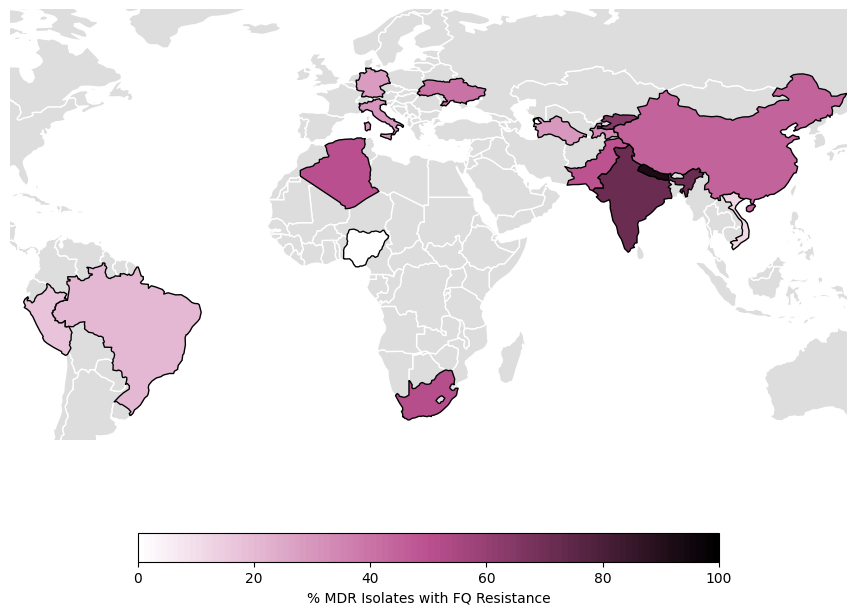

In [632]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
tb_world=pd.merge(world, fq_r_country_prev, left_on='iso_a3', right_on='COUNTRY', how='left')

cm = matplotlib.colors.LinearSegmentedColormap.from_list(
        'pinkwhite', [(1, 1, 1), (0.737, 0.3137, 0.5647),(0,0,0)], N=100)



#make graph
fig, ax = plt.subplots(1, 1,figsize=(15,8))




background=world.plot(ax=ax, color='#dddddd', edgecolor='w')
wp=tb_world.loc[tb_world.COUNTRY!='UNKNOWN'].plot(ax=ax,edgecolor='k',
                 figsize=(10, 10), column='PREV',
                 cmap=cm, vmin=0, vmax=100, legend=True, legend_kwds={'shrink': 0.5,
                                                    'label': "% MDR Isolates with FQ Resistance",
                                                   'orientation': "horizontal"})


ax.set_xlim(-85,135)
ax.set_ylim(-40,70)
ax.axis('off')

plt.savefig('fq_r_prev_map_fig.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()